In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 3c
commitnumber = 043bdfe
conc = 0.0004
dv = 0.001
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0, 0]
ng_refs = [3, 2, 4]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 300
vmax = 800
vmin = 720
w_diffuse = [(1.7, 1.6, 1.8), (1.8, 1.7), (1.5, 1.6, 1.7, 1.8)]
wgt = [(0.6, 0.4, 0.7), (0.7, 0.4), (0.3, 0.4, 0.85, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

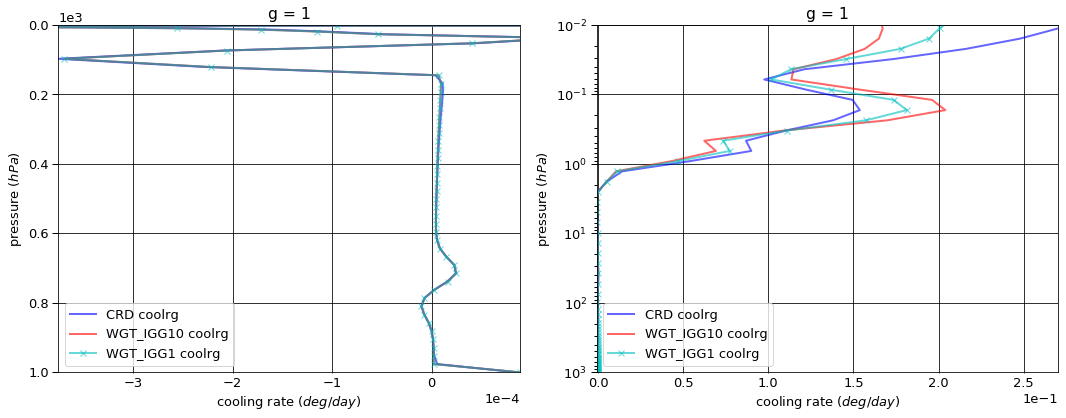

# Figure: cooling rate g-group 2

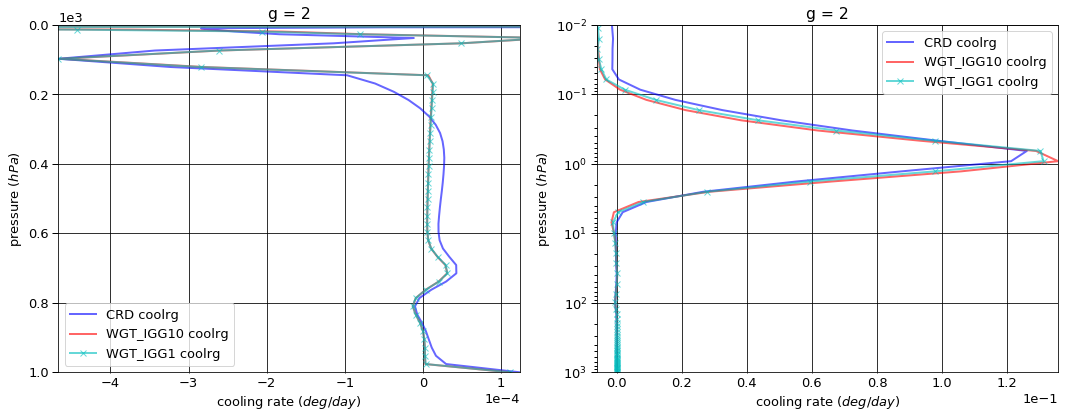

# Figure: cooling rate g-group 3

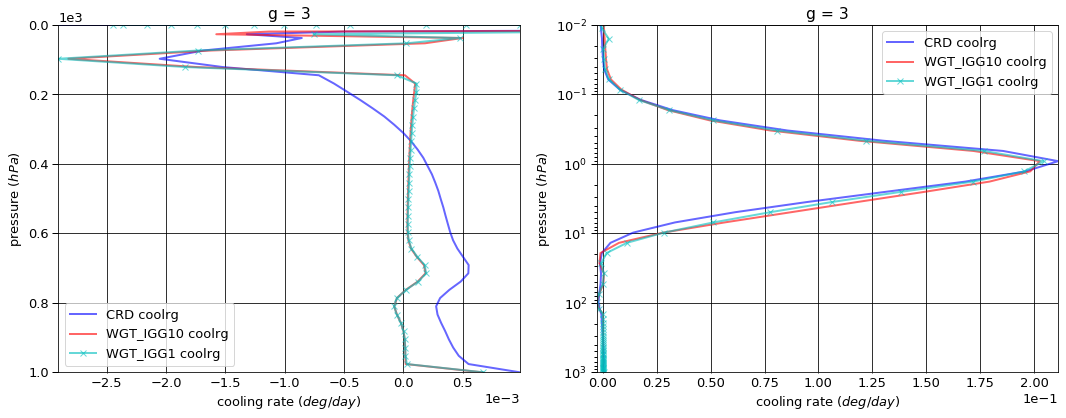

# Figure: cooling rate g-group 4

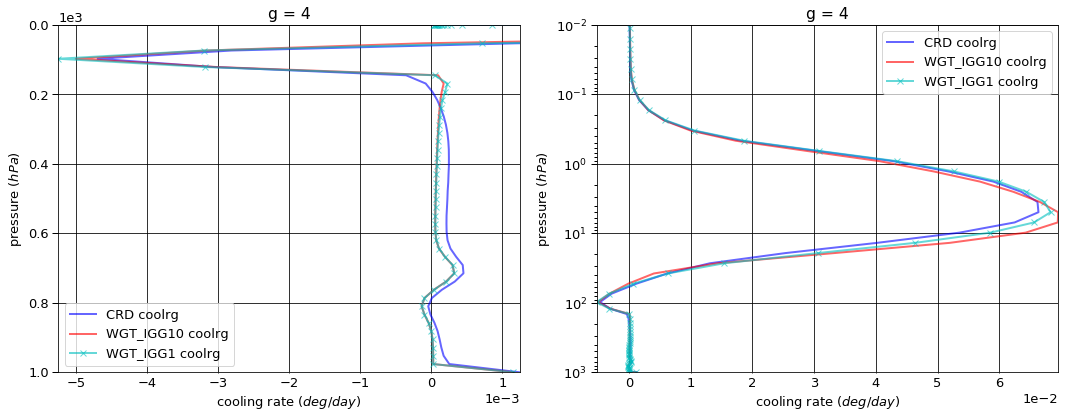

# Figure: cooling rate g-group 5

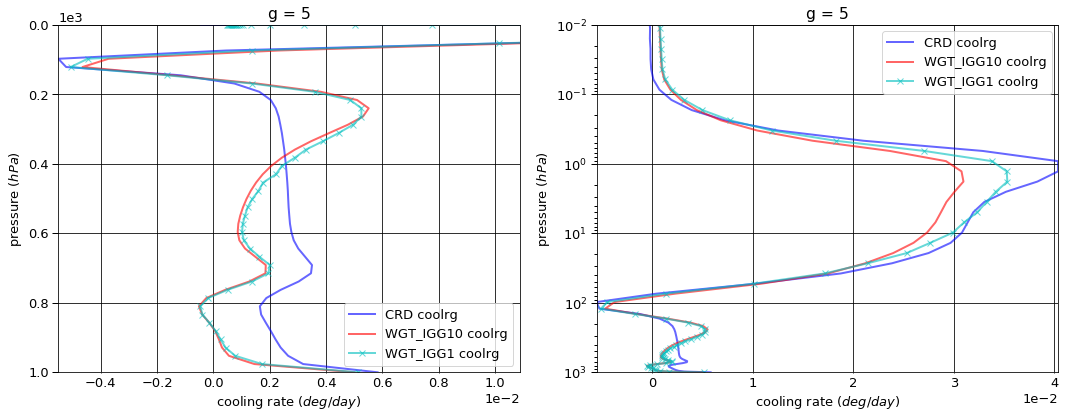

# Figure: cooling rate g-group 6

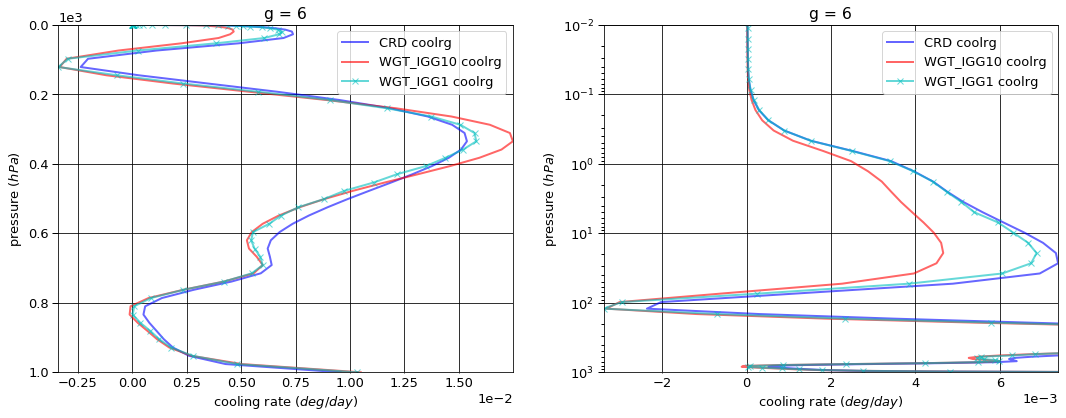

# Figure: cooling rate g-group 7

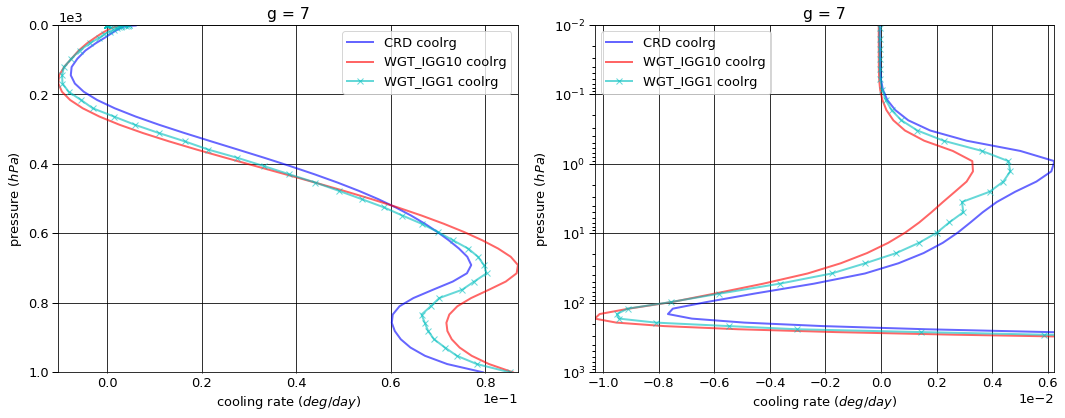

# Figure: cooling rate g-group 8

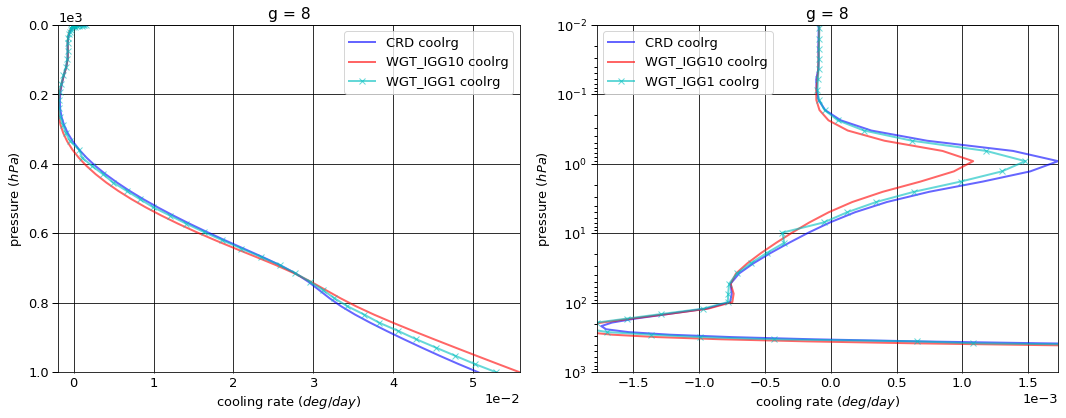

# Figure: cooling rate g-group 9

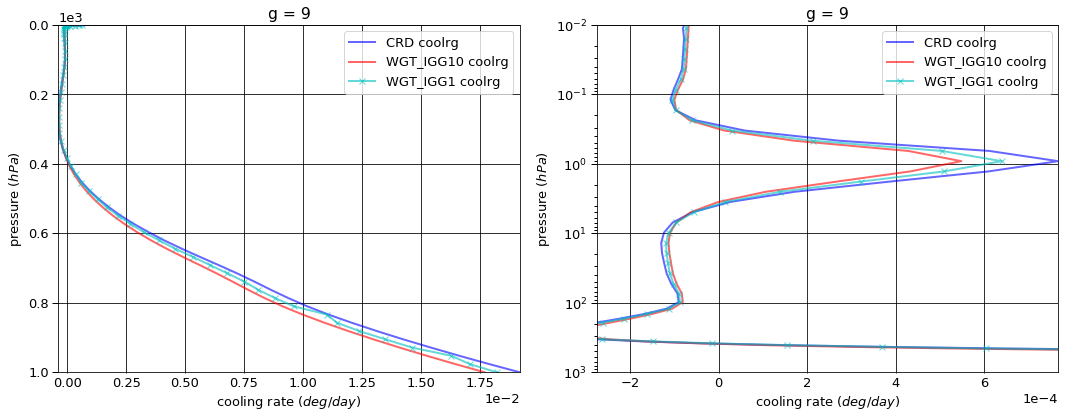

# Figure: cooling rate g-group total

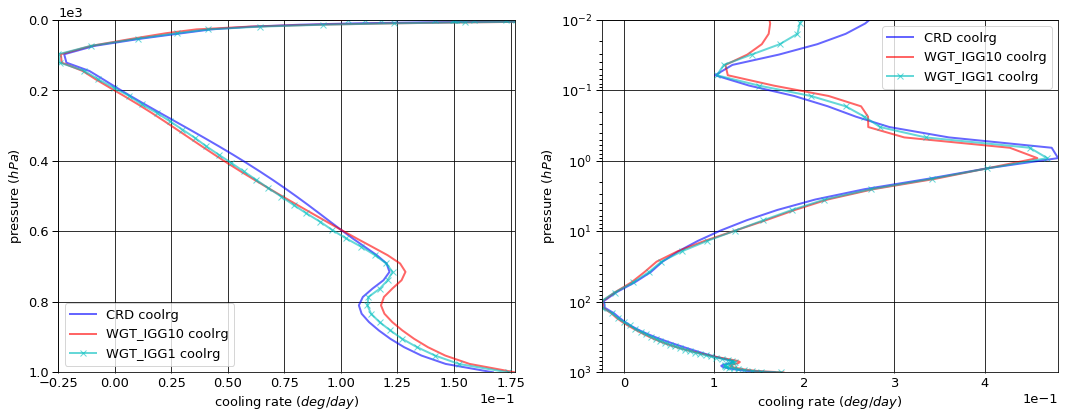

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.011777  0.000000  -0.011777
  1013.0   76     -0.030843  0.030590  -0.000252
2 0.0      1      -0.021743  0.000000  -0.021743
  1013.0   76     -0.038795  0.038285  -0.000510
3 0.0      1      -0.112905  0.000000  -0.112905
  1013.0   76     -0.231886  0.215908  -0.015978
4 0.0      1      -0.141065  0.000000  -0.141065
  1013.0   76     -0.404007  0.397954  -0.006053
5 0.0      1      -0.490826  0.000000  -0.490826
  1013.0   76     -1.383759  1.275455  -0.108304
6 0.0      1      -0.854861  0.000000  -0.854861
  1013.0   76     -2.477124  2.429005  -0.048119
7 0.0      1      -6.587153  0.000000  -6.587153
  1013.0   76    -10.416313  8.767361  -1.648951
8 0.0      1      -6.737023  0.000000  -6.737023
  1013.0   76     -7.501169  2.604186  -4.896983
9 0.0      1     -12.571911  0.000000 -12.571911
  1013.0   76    -12.739615  0.714840 -12.024776


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.010814  0.000000  -0.010814
  1013.0   76     -0.031729  0.031482  -0.000247
2 0.0      1      -0.022692  0.000000  -0.022692
  1013.0   76     -0.039688  0.039378  -0.000311
3 0.0      1      -0.107559  0.000000  -0.107559
  1013.0   76     -0.236426  0.234567  -0.001859
4 0.0      1      -0.140429  0.000000  -0.140429
  1013.0   76     -0.415025  0.411792  -0.003233
5 0.0      1      -0.323852  0.000000  -0.323852
  1013.0   76     -1.409300  1.390661  -0.018639
6 0.0      1      -0.809749  0.000000  -0.809749
  1013.0   76     -2.532171  2.481702  -0.050469
7 0.0      1      -6.714005  0.000000  -6.714005
  1013.0   76    -10.603690  9.052146  -1.551544
8 0.0      1      -6.744359  0.000000  -6.744359
  1013.0   76     -7.467883  2.605952  -4.861930
9 0.0      1     -12.343929  0.000000 -12.343929
  1013.0   76    -12.487597  0.635513 -11.852084


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.011046  0.000000  -0.011046
  1013.0   76     -0.031729  0.031482  -0.000247
2 0.0      1      -0.022354  0.000000  -0.022354
  1013.0   76     -0.039688  0.039374  -0.000314
3 0.0      1      -0.105500  0.000000  -0.105500
  1013.0   76     -0.236426  0.234516  -0.001910
4 0.0      1      -0.138296  0.000000  -0.138296
  1013.0   76     -0.415025  0.411792  -0.003233
5 0.0      1      -0.338208  0.000000  -0.338208
  1013.0   76     -1.409300  1.388359  -0.020941
6 0.0      1      -0.800351  0.000000  -0.800351
  1013.0   76     -2.532171  2.481074  -0.051097
7 0.0      1      -6.678590  0.000000  -6.678590
  1013.0   76    -10.603690  8.875290  -1.728400
8 0.0      1      -6.709495  0.000000  -6.709495
  1013.0   76     -7.467883  2.623176  -4.844707
9 0.0      1     -12.332577  0.000000 -12.332577
  1013.0   76    -12.487597  0.676167 -11.811430


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000963  0.000000  0.000963
  1013.0   76    -0.000887  0.000892  0.000005
2 0.0      1     -0.000950  0.000000 -0.000950
  1013.0   76    -0.000894  0.001092  0.000199
3 0.0      1      0.005347  0.000000  0.005347
  1013.0   76    -0.004540  0.018658  0.014119
4 0.0      1      0.000636  0.000000  0.000636
  1013.0   76    -0.011018  0.013838  0.002820
5 0.0      1      0.166974  0.000000  0.166974
  1013.0   76    -0.025541  0.115207  0.089665
6 0.0      1      0.045112  0.000000  0.045112
  1013.0   76    -0.055047  0.052697 -0.002350
7 0.0      1     -0.126853  0.000000 -0.126853
  1013.0   76    -0.187377  0.284785  0.097408
8 0.0      1     -0.007336  0.000000 -0.007336
  1013.0   76     0.033286  0.001766  0.035052
9 0.0      1      0.227982  0.000000  0.227982
  1013.0   76     0.252018 -0.079327  0.172692


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000731  0.000000  0.000731
  1013.0   76    -0.000887  0.000892  0.000005
2 0.0      1     -0.000611  0.000000 -0.000611
  1013.0   76    -0.000894  0.001089  0.000196
3 0.0      1      0.007405  0.000000  0.007405
  1013.0   76    -0.004540  0.018608  0.014068
4 0.0      1      0.002770  0.000000  0.002770
  1013.0   76    -0.011018  0.013839  0.002820
5 0.0      1      0.152618  0.000000  0.152618
  1013.0   76    -0.025541  0.112905  0.087363
6 0.0      1      0.054510  0.000000  0.054510
  1013.0   76    -0.055047  0.052070 -0.002978
7 0.0      1     -0.091437  0.000000 -0.091437
  1013.0   76    -0.187377  0.107929 -0.079449
8 0.0      1      0.027528  0.000000  0.027528
  1013.0   76     0.033286  0.018990  0.052276
9 0.0      1      0.239334  0.000000  0.239334
  1013.0   76     0.252018 -0.038673  0.213346

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.261338
  1001.112500 75     0.000086
2 0.000312    1     -0.004801
  1001.112500 75     0.000124
3 0.000312    1     -0.002783
  1001.112500 75     0.000980
4 0.000312    1      0.000015
  1001.112500 75     0.001247
5 0.000312    1     -0.000457
  1001.112500 75     0.005829
6 0.000312    1      0.000009
  1001.112500 75     0.009567
7 0.000312    1     -0.000030
  1001.112500 75     0.079484
8 0.000312    1     -0.000080
  1001.112500 75     0.050689
9 0.000312    1     -0.000064
  1001.112500 75     0.019188


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.106425
  1001.112500 75     0.000088
2 0.000312    1     -0.007960
  1001.112500 75     0.000111
3 0.000312    1     -0.001449
  1001.112500 75     0.000663
4 0.000312    1      0.000059
  1001.112500 75     0.001157
5 0.000312    1      0.000480
  1001.112500 75     0.005001
6 0.000312    1      0.000007
  1001.112500 75     0.010492
7 0.000312    1     -0.000087
  1001.112500 75     0.085807
8 0.000312    1     -0.000075
  1001.112500 75     0.055879
9 0.000312    1     -0.000056
  1001.112500 75     0.017700


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.158919
  1001.112500 75     0.000088
2 0.000312    1     -0.006107
  1001.112500 75     0.000112
3 0.000312    1     -0.002449
  1001.112500 75     0.000672
4 0.000312    1      0.000041
  1001.112500 75     0.001157
5 0.000312    1      0.000497
  1001.112500 75     0.005140
6 0.000312    1      0.000013
  1001.112500 75     0.010318
7 0.000312    1     -0.000067
  1001.112500 75     0.085152
8 0.000312    1     -0.000076
  1001.112500 75     0.052924
9 0.000312    1     -0.000060
  1001.112500 75     0.018217


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.154912
  1001.112500 75     0.000003
2 0.000312    1     -0.003159
  1001.112500 75    -0.000013
3 0.000312    1      0.001333
  1001.112500 75    -0.000318
4 0.000312    1      0.000044
  1001.112500 75    -0.000089
5 0.000312    1      0.000937
  1001.112500 75    -0.000828
6 0.000312    1     -0.000002
  1001.112500 75     0.000926
7 0.000312    1     -0.000057
  1001.112500 75     0.006323
8 0.000312    1      0.000004
  1001.112500 75     0.005190
9 0.000312    1      0.000008
  1001.112500 75    -0.001488


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.102418
  1001.112500 75     0.000003
2 0.000312    1     -0.001306
  1001.112500 75    -0.000012
3 0.000312    1      0.000333
  1001.112500 75    -0.000308
4 0.000312    1      0.000026
  1001.112500 75    -0.000089
5 0.000312    1      0.000954
  1001.112500 75    -0.000689
6 0.000312    1      0.000003
  1001.112500 75     0.000752
7 0.000312    1     -0.000038
  1001.112500 75     0.005667
8 0.000312    1      0.000004
  1001.112500 75     0.002234
9 0.000312    1      0.000004
  1001.112500 75    -0.000971

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.529264,0.000000,-27.529264
1013.0,76,-35.223510,16.473584,-18.749926



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.217388,0.000000,-27.217388
1013.0,76,-35.223510,16.883194,-18.340316



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.136417,0.000000,-27.136417
1013.0,76,-35.223510,16.761232,-18.462277



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.118757e-01,0.00000,0.311876
1013.0,76,-4.000000e-09,0.40961,0.409610



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.928472e-01,0.000000,0.392847
1013.0,76,-4.000000e-09,0.287648,0.287649


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.253148
1001.112500,75,0.167194



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.097344
1001.112500,75,0.176899



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.150709
1001.112500,75,0.173780



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.155804
1001.112500,75,0.009705



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.102439
1001.112500,75,0.006586


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000850,0.000901
2,0.001075,0.001127
3,0.006450,0.006712
4,0.011150,0.011783
5,0.038525,0.040010
6,0.068675,0.071889
7,0.290038,0.301040
8,0.213775,0.212014
9,0.369463,0.354524


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.310867e-19
2,2.133976e-20
3,1.970626e-21
4,1.774707e-21
5,1.647913e-22
6,5.838237e-22
7,6.101170e-23
8,6.375943e-24
9,2.959058e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.310867e-19,NaN,0.000850,0.000901,0.000850,0.000901,1.0
2,2.133976e-20,0.092345,0.001075,0.001127,0.001925,0.002028,1.0
3,1.970626e-21,0.092345,0.006450,0.006712,0.008375,0.008740,1.0
4,1.774707e-21,0.900580,0.011150,0.011783,0.019525,0.020522,10.0
5,1.647913e-22,0.092856,0.038525,0.040010,0.058050,0.060533,10.0
6,5.838237e-22,3.542806,0.068675,0.071889,0.126725,0.132421,500.0
7,6.101170e-23,0.104504,0.290038,0.301040,0.416763,0.433461,500.0
8,6.375943e-24,0.104504,0.213775,0.212014,0.630537,0.645476,500.0
9,2.959058e-25,0.046410,0.369463,0.354524,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
